Arshak Parsa


In [95]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sb

# Task 1 (PCA and K-means)

## Generate Data

In [96]:
seed = 13
np.random.seed(seed)
p, ns = 50, [20,20,20]
k = len(ns)
centroids = []
for _ in ns:
    centroids.append(np.random.uniform(-1,100,p))
X = np.vstack([np.random.multivariate_normal(centroids[i],np.diag(v = np.random.uniform(100,6000,p)),ns[i]) for i in range(k)])
label = np.hstack([np.repeat(i,n) for i,n in enumerate(ns)])

## PCA

explained var ratio: [0.13235002 0.09852382]


<Axes: xlabel='Z1', ylabel='Z2'>

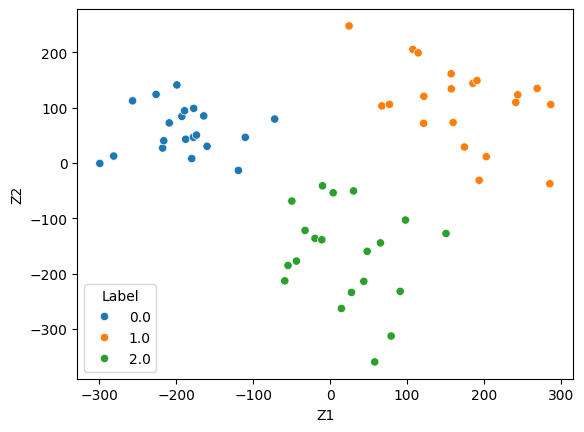

In [97]:
pca = PCA(n_components=2).fit(X)
print("explained var ratio:", pca.explained_variance_ratio_)
Xtrans = pd.DataFrame(np.hstack([pca.transform(X),label.reshape(-1,1)]), columns=["Z1", "Z2", "Label"])
Xtrans["Label"] = Xtrans["Label"].astype("category")
sb.scatterplot(Xtrans, x = "Z1", y = "Z2", hue="Label")

PCA separates the classes pretty well!

## K-Means on Raw Data

In [98]:
km_raw = KMeans(n_clusters=3, random_state=seed).fit(X)
print(km_raw.predict(X))
confusion_matrix(label,km_raw.predict(X)) # Bad confusion matrix

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1]


array([[ 0, 20,  0],
       [ 0,  0, 20],
       [ 2, 18,  0]])

We need to assign the best matching labels for each unique category

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        20
           1       1.00      1.00      1.00        20
           2       1.00      0.10      0.18        20

    accuracy                           0.70        60
   macro avg       0.84      0.70      0.62        60
weighted avg       0.84      0.70      0.62        60



<Axes: >

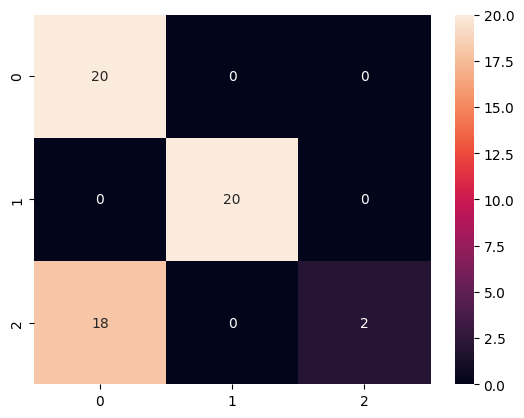

In [99]:
# Source - https://stackoverflow.com/a/45133875
# Posted by WhoIsJack
# Retrieved 2026-02-11, License - CC BY-SA 3.0

def find_best_matching(km,truth):
    # Prep
    k_labels = km.labels_  # Get cluster labels
    k_labels_matched = np.empty_like(k_labels)

    # For each cluster label...
    for k in np.unique(k_labels):

        # ...find and assign the best-matching truth label
        match_nums = [np.sum((k_labels==k)*(truth==t)) for t in np.unique(truth)]
        k_labels_matched[k_labels==k] = np.unique(truth)[np.argmax(match_nums)]
    return k_labels_matched

km_raw_bestmatch = find_best_matching(km_raw,label)
print(km_raw_bestmatch)
print(classification_report(label, km_raw_bestmatch))
sb.heatmap(confusion_matrix(label, km_raw_bestmatch), annot=True)

Not bad!

In [100]:
# Let's check wether the centroids of KMeans are near to the real centroids in our simulation?
for i,centroid in enumerate(centroids):
    print(f"Centroid l2-norm of cluster {i} = {((km_raw.cluster_centers_[i]-centroid)**2).sum()}")

Centroid l2-norm of cluster 0 = 186019.39996257937
Centroid l2-norm of cluster 1 = 82140.29075364007
Centroid l2-norm of cluster 2 = 88555.18547830812


## K-Means on Standardized Data

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00        20
           2       1.00      0.95      0.97        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



<Axes: >

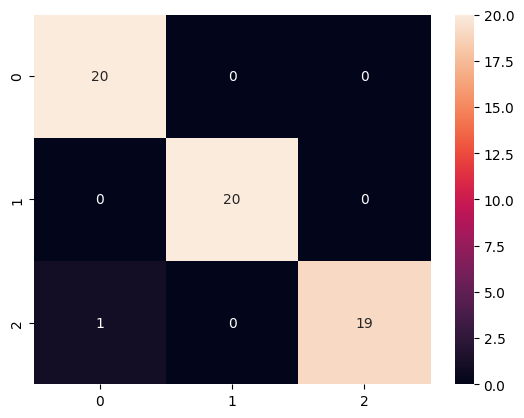

In [101]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
km_st = make_pipeline(StandardScaler() ,KMeans(n_clusters=3, random_state=7)).fit(X)
print(km_st.predict(X))
km_st_bestmatch = find_best_matching(km_st["kmeans"],label)
print(km_st_bestmatch)
print(classification_report(label, km_st_bestmatch))
sb.heatmap(confusion_matrix(label, km_st_bestmatch), annot=True)

Scaling improved our performance :(

## K-Means on PCA

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



<Axes: >

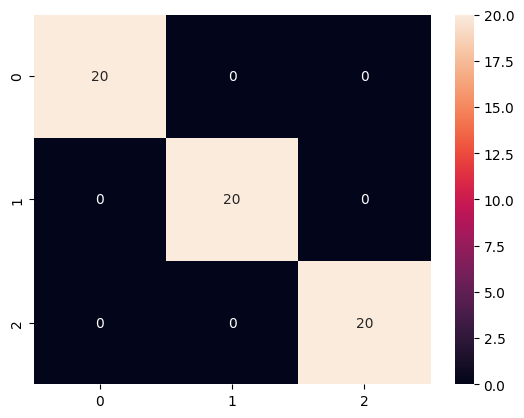

In [102]:
km_pca = make_pipeline(PCA(n_components=2), KMeans(n_clusters=3, random_state=7)).fit(X)
print(km_pca.predict(X))
km_pca_bestmatch = find_best_matching(km_pca["kmeans"],label)
print(km_pca_bestmatch)
print(classification_report(label, km_pca_bestmatch))
sb.heatmap(confusion_matrix(label, km_pca_bestmatch), annot=True)

PCA gave the best performance in this example!

# Task 2 (Hierarchical Clustering)

In [103]:
import statsmodels.api as sm

USArrests = sm.datasets.get_rdataset("USArrests", cache=True).data
USArrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


## Euclidean Distance

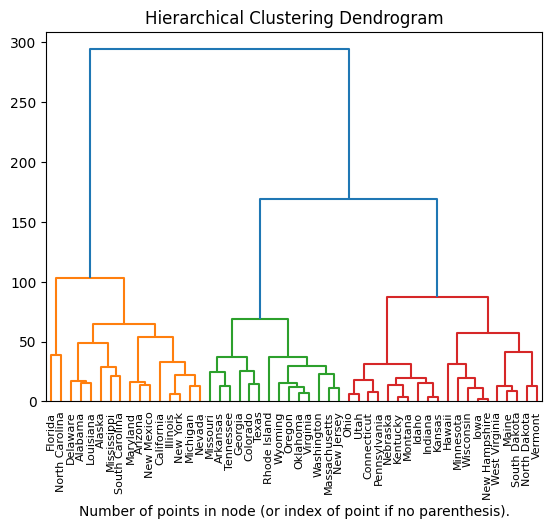

In [104]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="complete", metric="euclidean", compute_distances=True, n_clusters=3).fit(USArrests)

def plot_dendrogram(model, **kwargs):
    plt.title("Hierarchical Clustering Dendrogram")
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()


plot_dendrogram(clustering, truncate_mode="level", labels= USArrests.index, color_threshold = 150)

## Extracting Clusters


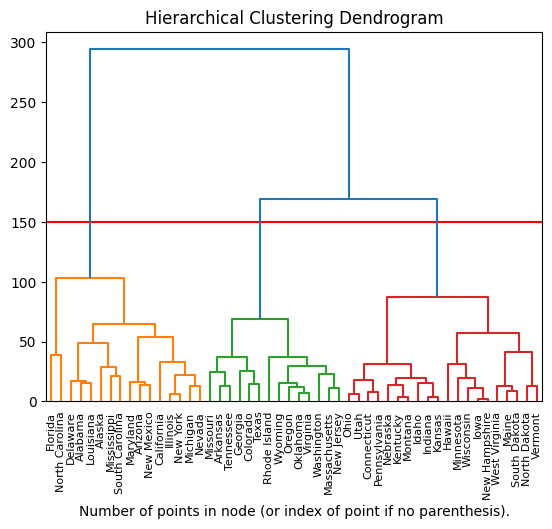

In [105]:
plt.axhline(150, color = "red")
plot_dendrogram(clustering, truncate_mode="level", labels = USArrests.index , color_threshold = 150)

In [106]:
for i in range(3):
    print(list(USArrests.index[clustering.labels_==i]))

['Alabama', 'Alaska', 'Arizona', 'California', 'Delaware', 'Florida', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina']
['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'Ohio', 'Pennsylvania', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wisconsin']
['Arkansas', 'Colorado', 'Georgia', 'Massachusetts', 'Missouri', 'New Jersey', 'Oklahoma', 'Oregon', 'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wyoming']


## Impact of Scaling

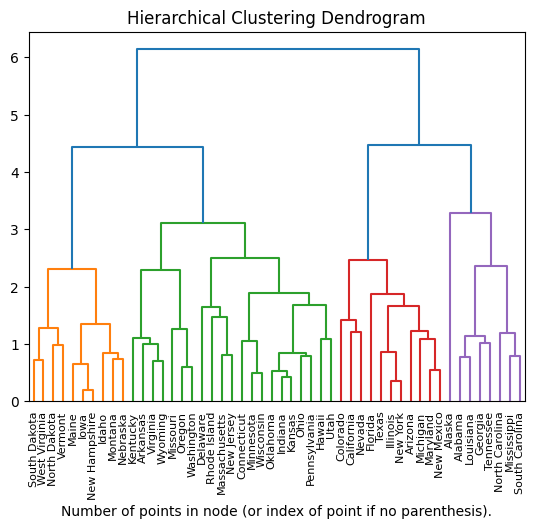

In [107]:
clustering_st = make_pipeline(StandardScaler() ,AgglomerativeClustering(linkage="complete", metric="euclidean", compute_distances=True, n_clusters=3)).fit(USArrests)

plot_dendrogram(clustering_st["agglomerativeclustering"], truncate_mode="level", labels= USArrests.index)

## Correlation-based Distance

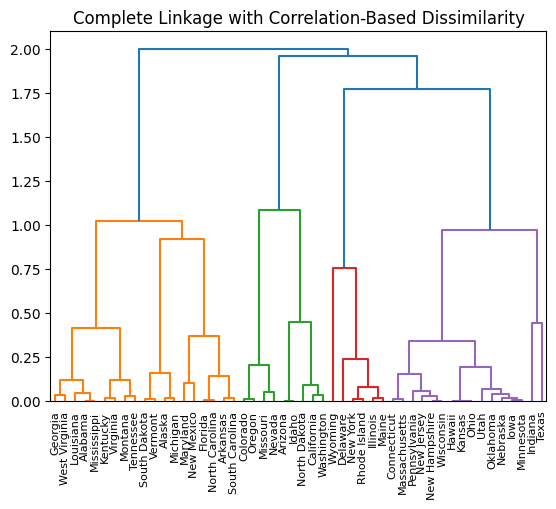

In [108]:
from ISLP.cluster import compute_linkage
corD = 1 - np.corrcoef(StandardScaler().fit_transform(USArrests))
hc_cor = AgglomerativeClustering(linkage='complete',compute_distances=True,n_clusters=3,metric='precomputed')
hc_cor.fit(corD)
linkage_cor = compute_linkage(hc_cor)
dendrogram(linkage_cor, labels=USArrests.index)
plt.title("Complete Linkage with Correlation-Based Dissimilarity");

## Comparison

In [109]:
import us
import plotly.express as px
USArrests["county"] = USArrests.index.to_series().apply(lambda x : us.states.lookup(x).abbr)

In [110]:
def plotUSA0(c):
    df = USArrests.reset_index()
    fig = px.choropleth(df,locations="county", locationmode="USA-states", color=c, scope="usa")
    fig.show()
plotUSA0("Murder")

In [111]:
plotUSA0("Rape")

In [112]:
plotUSA0("Assault")

In [113]:
plotUSA0("UrbanPop")

In [114]:
def plotUSA(c):
    df = USArrests.reset_index()
    df["cluster"] = c.labels_
    fig = px.choropleth(df,locations="county", locationmode="USA-states", color="cluster", scope="usa")
    fig.show()
plotUSA(clustering)

In [115]:
plotUSA(clustering_st["agglomerativeclustering"])

In [116]:
plotUSA(hc_cor)